 Imports

In [7]:
import numpy as np
import pandas as pd
import genData
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

Load our data sets for consistant and reproducible results

In [8]:
seed = 1528538182
testDataSeed = 5412654
genData.def_seed = seed

In [9]:
trainA = genData.create_A()
testA = genData.create_A(seed=testDataSeed)
trainA

,x,y,target
0,-50.12,29.11,1
1,12.61,50.87,1
2,22.33,58.29,1
3,78.93,-94.23,-1
4,-41.31,-25.08,-1
...,...,...,...
995,-17.98,7.35,1
996,-52.02,-83.95,-1
997,-58.32,-16.29,-1
998,68.00,-62.56,-1


In [10]:
trainB = genData.create_B(size=1000)
testB = genData.create_B(seed=testDataSeed,size=1000)
train_extra = {"x":[],"y":[],"target":[]}
test_extra = {"x":[],"y":[],"target":[]}

while len(train_extra["target"]) < 200 or len(test_extra["target"])<250:
    train_x = np.random.randint(-300,301)
    train_y = np.random.randint(-300,301)
    test_x = np.random.randint(-300,301)
    test_y = np.random.randint(-300,301)
    
    if 40000 <= train_x**2 + train_y**2 and train_x**2 + train_y**2 <= 90000:
        train_extra["x"].append(train_x/100)
        train_extra["y"].append(train_y/100)
        train_extra["target"].append(1)
    if 40000 <= test_x**2 + test_y**2 and test_x**2 + test_y**2 <= 90000:
        test_extra["x"].append(test_x/100)
        test_extra["y"].append(test_y/100)
        test_extra["target"].append(1)

train_extra = pd.DataFrame(train_extra)
trainB = trainB.append(train_extra,ignore_index=True).sample(frac=1).reset_index(drop=True)

test_extra = pd.DataFrame(test_extra)
testB = testB.append(test_extra,ignore_index=True)

trainB

,x,y,target
0,-1.37,-2.26,1
1,75.51,57.98,-1
2,-2.61,0.41,1
3,58.72,-91.42,-1
4,84.77,-25.00,-1
...,...,...,...
1269,2.73,0.25,1
1270,-9.97,77.65,-1
1271,-5.51,-80.78,-1
1272,99.99,-34.20,-1


## Adaline Model

In [11]:
class Adaline:
    def __init__(self,seed:int = None, learning_rate:float=0.000001, bias:float=0.2, repeats:int=10000, possible_targets=None,epsilon=0.00000001):
        self.rng = np.random.RandomState(seed)
        self.repeats = repeats
        self.learning_rate = learning_rate
        self.bias = bias
        self.possible_targets = possible_targets
        self.epsilon = epsilon
        

    def fit(self,data,target,verbose:int=0,precision:int=4,max_step:int=10,logRate:int=5) -> dict:
        
        self.weights = self.rng.rand(data.shape[1],1)
        if self.possible_targets == None:
            self.possible_targets = np.unique(target)
        
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #logging
        past_MSE = [float("inf")]

        #save each epoch
        stats = {"Epoch":[],"bias":[],"MSE":[]}
        for feature_i in range(data.shape[0]):
            stats["w_"+str(feature_i)] = []
            stats["deltaW_"+str(feature_i)] = []
        

        #make sure we don't enter an infinite loop if our model doesn't converge
        for i in range(self.repeats):
            errors = []
            
            #repeat for all data samples
            for x_i in range(data.shape[1]):
                #sum(w_i*x_i) for all features 
                Y = self.bias + np.sum(data[:,[x_i]]*self.weights,axis=0)[0]
                delta = (target[x_i]-Y)               
                deltaW = self.learning_rate*delta*data[:,[x_i]]
                
                #adjust weights and bias
                self.weights = self.weights + deltaW
                self.bias = self.bias+self.learning_rate*delta

                #squared error 
                errors.append((delta**2))
                
            mse = sum(errors)/len(errors)
            past_MSE.append(mse)

            if i%logRate == 0:
                #save stats of each value in our data
                stats["bias"].append(round(self.bias,precision))
                stats["MSE"].append(round(mse,precision))
                stats["Epoch"].append(i)
                for feature_i in range(data.shape[0]):
                    stats["w_"+str(feature_i)].append(round(self.weights[feature_i][0],precision))
                    stats["deltaW_"+str(feature_i)].append(round(deltaW[feature_i][0],precision))
                
                
            
            #print stats
            if verbose>=1 and i%logRate == 0:
                print("Epoch",i)
                print(mse)
                if verbose>=2:
                    df = pd.DataFrame(stats)
                    print(df)
                print("--------")

            #stop if our mse is not changing at all
            if len(past_MSE) > max_step and all(past_MSE[-1] == x for x in past_MSE[-max_step:]):
                break
        
        model_performance = pd.DataFrame(stats)
        return model_performance


    def predict(self,data):
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #get vector of predicted target values
        raw_target = np.ravel(self.bias+np.sum(data*self.weights,axis=0))
        absMat = []

        #(possible targets, samples) matrix such that each row is the absolute difference between the the value we recieved for each sample and the possible target
        for val in self.possible_targets:
            absMat.append(np.abs(raw_target - val))
        absMat = np.array(absMat)
        #indexs of the minimum value per column (index i such that abs(target_i, value) is minimal) 
        targetIndexes = np.argmin(absMat,axis=0)
        target = []

        #return the our prediction
        for i in targetIndexes:
            target.append(self.possible_targets[i])
        return np.array(target) 

## Part A

In [16]:
ad = Adaline(seed, bias=0.1)
perfomance = ad.fit(trainA.loc[:,["x","y"]],trainA["target"],verbose=1, logRate = 10)

Epoch 0
239.65326523132433
--------
Epoch 10
0.27653263586005444
--------
Epoch 20
0.2762201587450656
--------
Epoch 30
0.27591387287071073
--------
Epoch 40
0.27561365559009127
--------
Epoch 50
0.27531938668568096
--------
Epoch 60
0.2750309483212117
--------
Epoch 70
0.27474822499451057
--------
Epoch 80
0.27447110349126463
--------
Epoch 90
0.27419947283970975
--------
Epoch 100
0.2739332242662083
--------
Epoch 110
0.2736722511517125
--------
Epoch 120
0.27341644898908973
--------
Epoch 130
0.27316571534129014
--------
Epoch 140
0.27291994980034273
--------
Epoch 150
0.2726790539471698
--------
Epoch 160
0.27244293131218933
--------
Epoch 170
0.27221148733670214
--------
Epoch 180
0.2719846293350423
--------
Epoch 190
0.2717622664574786
--------
Epoch 200
0.27154430965385085
--------
Epoch 210
0.27133067163792146
--------
Epoch 220
0.27112126685244414
--------
Epoch 230
0.2709160114349082
--------
Epoch 240
0.27071482318398166
--------
Epoch 250
0.27051762152659786
--------
Epoch 

In [17]:
testA_res = ad.predict(testA.loc[:,["x","y"]])
accuracy_score(testA["target"],testA_res)

0.992

### Model progression 

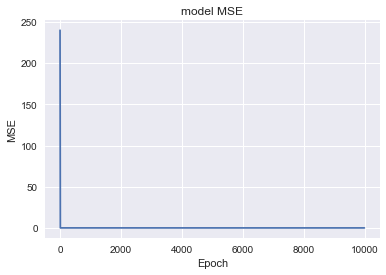

In [18]:
plt.plot(perfomance["Epoch"],perfomance["MSE"])
plt.title("model MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [19]:
perfomance

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
0,0,0.0992,239.6533,0.0280,-0.0,0.0189,0.0
1,10,0.0979,0.2765,-0.0006,-0.0,0.0145,0.0
2,20,0.0967,0.2762,-0.0006,-0.0,0.0145,0.0
3,30,0.0954,0.2759,-0.0006,-0.0,0.0145,0.0
4,40,0.0942,0.2756,-0.0006,-0.0,0.0146,0.0
...,...,...,...,...,...,...,...
995,9950,-0.0275,0.2608,-0.0005,-0.0,0.0146,0.0
996,9960,-0.0275,0.2608,-0.0005,-0.0,0.0146,0.0
997,9970,-0.0275,0.2608,-0.0005,-0.0,0.0146,0.0
998,9980,-0.0275,0.2608,-0.0005,-0.0,0.0146,0.0


In [20]:
ad2 = Adaline(seed,bias=0.05,learning_rate=0.0000004)
perfomance2 = ad2.fit(trainB.loc[:,["x","y"]], trainB["target"], verbose=2, logRate = 10)

Epoch 0
434.62771331894965
   Epoch    bias       MSE     w_0  deltaW_0     w_1  deltaW_1
0      0  0.0492  434.6277  0.1934   -0.0006  0.0185    0.0003
--------
Epoch 10
1.0549108743302407
   Epoch    bias       MSE     w_0  deltaW_0     w_1  deltaW_1
0      0  0.0492  434.6277  0.1934   -0.0006  0.0185    0.0003
1     10  0.0458    1.0549 -0.0003   -0.0000 -0.0002    0.0000
--------
Epoch 20
1.0510646840859632
   Epoch    bias       MSE     w_0  deltaW_0     w_1  deltaW_1
0      0  0.0492  434.6277  0.1934   -0.0006  0.0185    0.0003
1     10  0.0458    1.0549 -0.0003   -0.0000 -0.0002    0.0000
2     20  0.0427    1.0511 -0.0003   -0.0000 -0.0002    0.0000
--------
Epoch 30
1.047259740068161
   Epoch    bias       MSE     w_0  deltaW_0     w_1  deltaW_1
0      0  0.0492  434.6277  0.1934   -0.0006  0.0185    0.0003
1     10  0.0458    1.0549 -0.0003   -0.0000 -0.0002    0.0000
2     20  0.0427    1.0511 -0.0003   -0.0000 -0.0002    0.0000
3     30  0.0396    1.0473 -0.0003   -0.0000

KeyboardInterrupt: 

In [ ]:
#print(perfomance2[10]["stats"])

In [ ]:
testB_res = ad2.predict(testB.loc[:,["x","y"]])
testB_res

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [ ]:
accuracy_score(testB["target"],testB_res)

0.8

In [ ]:
testB["target"].value_counts()

-1    1000
 1     250
Name: target, dtype: int64

In [ ]:
testB["results"]=testB_res

In [ ]:
testB["results"].value_counts()

-1    1250
Name: results, dtype: int64

In [ ]:
backgroundPoints = [[],[]]
for i in range(-100,100):
    temp = []
    for j in range(-100,100):
        backgroundPoints[0].append(i*100)
        backgroundPoints[1].append(j*100)
print(np.array(backgroundPoints).shape)
backgroundPoints = genData.create_B(raw_data=backgroundPoints,size=None)
backgroundPoints

(2, 40000)


,x,y,target
0,-100.0,-100.0,-1
1,-100.0,-99.0,-1
2,-100.0,-98.0,-1
3,-100.0,-97.0,-1
4,-100.0,-96.0,-1
...,...,...,...
39995,99.0,95.0,-1
39996,99.0,96.0,-1
39997,99.0,97.0,-1
39998,99.0,98.0,-1


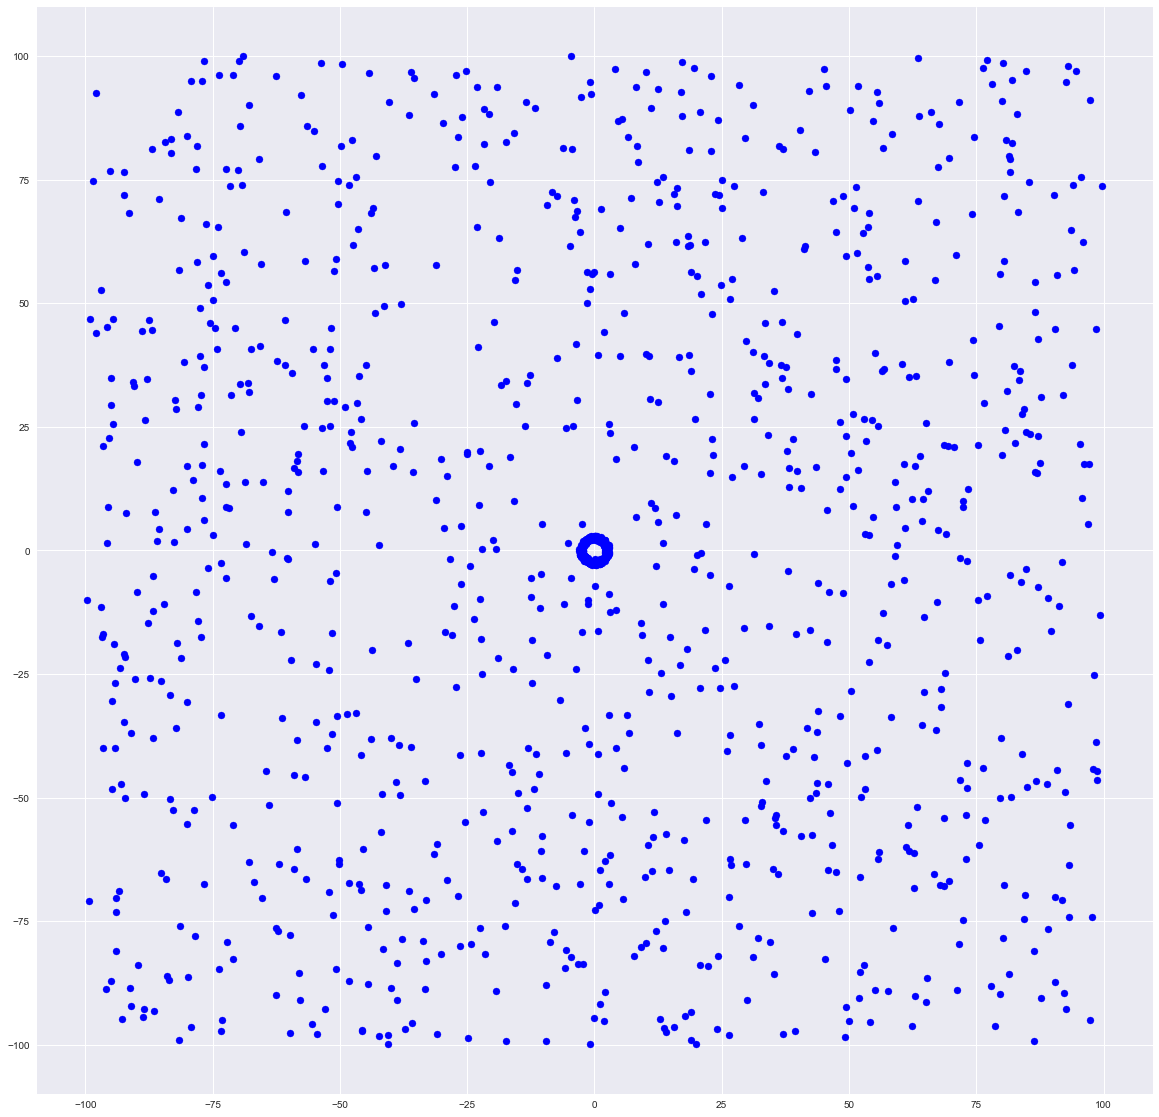

In [ ]:
background_1 = backgroundPoints[backgroundPoints["target"] == 1]
background_neg_1 = backgroundPoints[backgroundPoints["target"] != 1]

targets_1 = testB[testB["results"] == 1]
targets_neg_1 = testB[testB["results"] != 1]

plt.figure(figsize=(20,20))
plt.scatter(targets_neg_1["x"],targets_neg_1["y"], c='b')
plt.scatter(targets_1["x"],targets_1["y"], c='r')

#plt.scatter(background_1["x"],background_1["y"], c='r',alpha=0.4)
#plt.scatter(background_neg_1["x"],background_neg_1["y"], c='b',alpha=0.4)

